# Notebook Setup

In [1]:
from IPython.display import clear_output

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install matplotlib
%pip install torchvision
%pip install tqdm

clear_output()

In [2]:
import torch

import torch.nn as nn

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam

from torchvision.transforms.functional import to_tensor

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
%matplotlib inline

plt.style.use("bmh")
plt.rcParams.update({
    "figure.figsize" : (12, 8),
    "axes.facecolor" : "white",
    "axes.edgecolor":  "black"
    })

# plt.style.use('dark_background')

In [4]:
def show_images(images, labels, ncols=4, nrows=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    
    # get an appropriate number of images
    images = images[:ncols * nrows]

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = axes[i // ncols, i % ncols]
        image = image.reshape(28, 28)
        ax.imshow(image, cmap='gray')
        ax.set_title(label)
        ax.axis('off')
    plt.show()

# Contents:

1. Implementation of 1-2 layer NN fin pytorch which classifies MNIST dataset

About MNIST:

the dataset consists of images of 28x28 size. The image each contains a handwritten digit from 0 to 9. Our model needs to take this image and classify it to the correct digit.


You need to know:

1. **pytorch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

In [5]:
# Load the full datasets
train_data = MNIST(root='./datasets', train=True, download=True, transform=to_tensor)
test_data = MNIST(root='./datasets', train=False, download=True, transform=to_tensor)

# Define the subset size
subset_size = ______ # images

# Generate a random subset of indices for the training data
subset_indices = np.random.choice(len(train_data), subset_size, replace=False)

# Create the subset using torch.utils.data.Subset
train_subset = Subset(train_data, subset_indices)

In [6]:
batch_size = __

# Dataloaders are used to easily create batches of data so we can perform batch gradient descent for faster learning
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

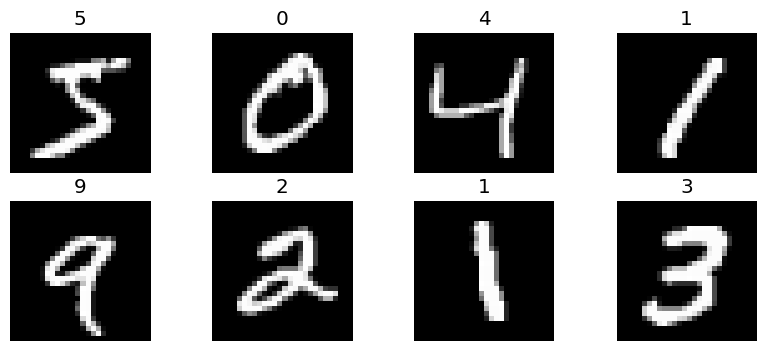

In [7]:
# Displaying a few images from the training dataset to confirm correct loading.
# The labels correspond to the digits (0-9) represented in the images.

sample_data, sample_labels = next(iter(train_loader))
sample_data, sample_labels = sample_data.numpy(), sample_labels.numpy()  # Convert to NumPy format for visualization

show_images(sample_data, sample_labels)

## Models

let's create the architecture of our models

Instead of sigmoid activation, we'll use softmax activation

The difference is:
- sigmoid brings each value in the range 0-1
- softmax takes a vector and changes the value into probabilities: i.e the sum of those values = 1. The highest value in the original vector retains the highest value in softmax output

Here's the formula for softmax:

$$
\text{Softmax}(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

### Activation Functions
Activation functions introduce non-linearity into the network. We'll use:
- **ReLU** (Rectified Linear Unit): For the hidden layer, to capture non-linear relationships.
- **Softmax**: For the output layer, to convert raw scores into probabilities.

In [8]:
# Define a single-layer neural network
class NN1Layer(nn.Module):

    def __init__(self, num_inp, num_out):
        super(NN1Layer, self).__init__()
        
        # Define a single fully connected layer
        self.layer_1 = nn.Linear(num_inp, num_out)
        self.softmax = nn.Softmax(dim=1)  # Apply softmax along the feature dimension (dim=1) to get probabilities

    def forward(self, x):
        # Forward pass: Apply the single layer and softmax activation
        z = self.layer_1(x)  # Linear transformation
        a = self.softmax(z)  # Convert logits to probabilities
        
        return a


# Define a two-layer neural network
class NN2Layer(nn.Module):

    def __init__(self, num_inp, num_hidden, num_out):
        super(NN2Layer, self).__init__()
        
        # Define two fully connected layers
        self.layer_1 = _____________________________  # First layer with input size and hidden layer size
        self.layer_2 = _____________________________  # Second layer with hidden layer size and output size
        
        # Define activation functions
        self.hidden_activation = nn.ReLU()  # ReLU activation function for hidden layer
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for output layer (dim=1 for feature dimension)

    def forward(self, x):
        # Forward pass through the two-layer network
        z1 = self.layer_1(x)  # Linear transformation: input to hidden layer
        a1 = self.hidden_activation(z1)  # Apply ReLU activation
        
        z2 = self.layer_2(a1)  # Linear transformation: hidden to output layer
        a2 = self.softmax(z2)  # Apply softmax to get probabilities
        
        return a2

## The main training loop, with batch gradient descent.



Declare model, it's params, optimizers and criterion etc

We'll also declare a device here. This will let us use GPU
you can see how much difference a GPU makes by changing the device param to cpu and cuda

In [9]:
num_epochs = 12
lr = 1e-4

ni = __ * __
nh = __
no = __

# model = NN1Layer(ni, no)       # 28*28 because that's the input side. 10 because that's the numbber of classes (0-9)
model = NN2Layer(ni, nh, no)     # The 2 layer one is equivalent to the one we implemented in numpy

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()   # multi-class

device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

train_losses = []
val_losses = []
accuracies = []

Using device cpu


### Pre-train performance

Question: 
 - What do you think the accuracy of our model?s

In [10]:
model.eval()
correctly_labelled = 0

with torch.no_grad():

	val_epoch_weighted_loss = 0

	for val_batch_X, val_batch_y in test_loader:

		val_batch_X = val_batch_X.view(-1, 28*28).to(device)
		val_batch_y = val_batch_y.to(device)

		val_batch_y_probs = model(val_batch_X)

		loss = criterion(val_batch_y_probs, val_batch_y)
		val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

		# convert probailities to labels by picking the label (index) with the highest prob
		val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  

		correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
val_losses.append(val_epoch_loss)

print(f'validation loss = {val_epoch_loss}. labeled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

validation loss = 2.3033735557556154. labeled 664/10000 correctly (6.64% accuracy)


### Training the model

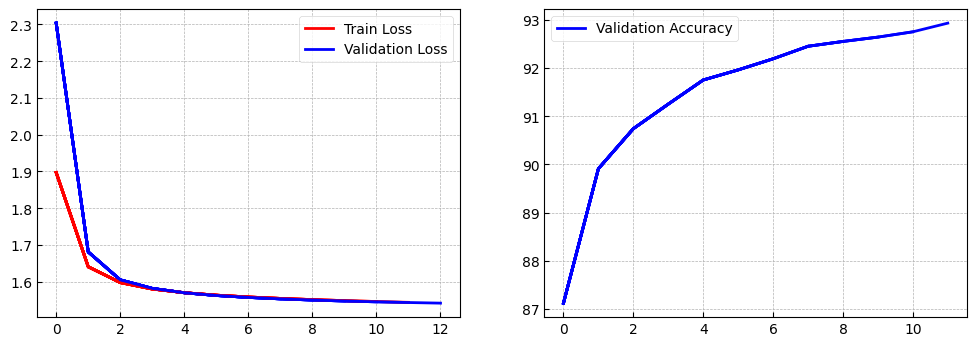

Training: 100%|██████████| 12/12 [00:25<00:00,  2.16s/Epochs, Train Loss=1.54, Validation Loss=1.54, Validation Accuracy=92.9]

Training complete on device cpu. Change device variable and run again to see the difference.


In [11]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with two subplots
dh = display(fig, display_id=True)  # Dynamically display the plot

with tqdm(total=num_epochs, desc='Training', unit='Epochs', colour='Green') as pbar:  # Progress bar for tracking epochs
    for epoch_no in range(num_epochs):  # Loop through the specified number of epochs

        model.train()  # Switch model to training mode

        epoch_weighted_loss = 0  # Initialize the epoch loss accumulator

        for batch_X, batch_y in train_loader:  # Loop through training data batches

            # Preprocess input batch
            batch_X = batch_X.view(-1, ni).to(device)  # Flatten input images to vectors and move to device
            batch_y = batch_y.to(device)  # Move labels to the same device as the model

            # Forward pass: Get probabilities for each class
            batch_y_probs = model(batch_X)  # Outputs shape [N, 10], where N is batch size and 10 is class count

            # Compute loss for the batch
            loss = criterion(batch_y_probs, batch_y)

            optimizer.zero_grad()  # Clear gradients from the previous batch
            loss.backward()  # Backward pass to calculate gradients
            optimizer.step()  # Update model weights using the optimizer

            # Accumulate the weighted loss for the batch
            epoch_weighted_loss += len(batch_y) * loss.item()

        # Calculate and store the epoch's average loss
        epoch_loss = epoch_weighted_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)  # Track training loss for visualization

        # Validation Phase
        model.eval()  # Switch model to evaluation mode (disables training-specific layers like dropout)
        correctly_labelled = 0  # Initialize correct prediction count for validation

        with torch.no_grad():  # Disable gradient tracking for validation
            val_epoch_weighted_loss = 0  # Initialize validation epoch loss accumulator

            for val_batch_X, val_batch_y in test_loader:  # Loop through validation data batches
                # Preprocess input batch
                val_batch_X = val_batch_X.view(-1, 28 * 28).to(device)  # Flatten validation images
                val_batch_y = val_batch_y.to(device)  # Move validation labels to device

                # Forward pass: Get probabilities for each class
                val_batch_y_probs = model(val_batch_X)

                # Compute loss for the validation batch
                loss = criterion(val_batch_y_probs, val_batch_y)
                val_epoch_weighted_loss += len(val_batch_y) * loss.item()

                # Convert probabilities to predicted labels
                val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

                # Count correctly predicted labels
                correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

        # Calculate and store the epoch's average validation loss
        val_epoch_loss = val_epoch_weighted_loss / len(test_loader.dataset)
        val_losses.append(val_epoch_loss)  # Track validation loss for visualization

        # Update progress bar with the latest metrics
        pbar.update(1)
        pbar.set_postfix({
            'Train Loss': epoch_loss,
            'Validation Loss': val_epoch_loss,
            'Validation Accuracy': correctly_labelled / len(test_loader.dataset) * 100
        })

        accuracies.append(correctly_labelled / len(test_loader.dataset) * 100)

        # Dynamically update the plots for loss and accuracy
        ax_loss.plot(train_losses, color='red', label='Train Loss')
        ax_loss.plot(val_losses, color='blue', label='Validation Loss') 
        ax_acc.plot(accuracies, color='blue', label='Validation Accuracy')

        if not epoch_no:
            ax_acc.legend()
            ax_loss.legend()
        dh.update(fig)  # Update displayed figure
    plt.close()  # Close the plot once training is complete

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

### Other Exercises:

#### Ex1. visualizing shapes

In [12]:
print(val_batch_X.shape, val_batch_y.shape)  # 784 is 28*28
print(val_batch_y_probs.shape)  # inference from model
print(val_batch_y_pred.shape)  # probabilities converted

print("\n\nTo verify softmax converts inputs into probabilities (sum of which is 1), let's sum those probabilities and see if we get 1's: \n")
print(f'{val_batch_y_probs.sum(1)=}')

print(f'\n{val_batch_y_probs.sum(1).shape=}')

print('\n\nLets see argmax in action')
print("Here's one of the input to argmax\n")
test_idx = 15
print(val_batch_y_probs[test_idx].cpu())  # .cpu() brings a tensor back to cpu device from any other it might be on (like cuda)
print("\n\nHere's its output")
print(val_batch_y_pred[test_idx].cpu())

torch.Size([16, 784]) torch.Size([16])
torch.Size([16, 10])
torch.Size([16])


To verify softmax converts inputs into probabilities (sum of which is 1), let's sum those probabilities and see if we get 1's: 

val_batch_y_probs.sum(1)=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

val_batch_y_probs.sum(1).shape=torch.Size([16])


Lets see argmax in action
Here's one of the input to argmax

tensor([6.4162e-10, 1.2921e-19, 2.0508e-08, 2.5132e-16, 3.0909e-11, 7.1307e-11,
        1.0000e+00, 2.8979e-17, 6.4064e-13, 6.2544e-16])


Here's its output
tensor(6)


#### Ex2. Saving and loading the model

In [13]:
# you can load save the model's state dict like this
torch.save(model.state_dict(), 'MNIST_classifier.pt')  # take a look at the storage section if you're on colab

In [14]:
# Initialize an empty model with the same architecture as the saved model
loaded_model = NN2Layer(28 * 28, 32, 10)  # Model with 28*28 input features, 32 hidden units, and 10 output classes
loaded_model.eval().to(device)  # Set the model to evaluation mode and move it to the specified device

print('Before loading model')

# Evaluate the untrained model
with torch.no_grad():  # Disable gradient tracking for inference
    probs = loaded_model(val_batch_X)  # Get class probabilities from the untrained model
    preds = probs.argmax(dim=1)  # Convert probabilities to predicted class labels

    # Compare predictions with actual labels and print the number of correct predictions
    print(f'{(preds == val_batch_y).sum()}/{len(preds)} correct')  # Accuracy before loading the trained weights

print('After loading model')

# Load the saved model weights into the initialized model
loaded_model.load_state_dict(torch.load('MNIST_classifier.pt'))  # Load trained weights from the saved file

# Evaluate the trained model
with torch.no_grad():  # Disable gradient tracking for inference
    probs = loaded_model(val_batch_X)  # Get class probabilities from the trained model
    preds = probs.argmax(dim=1)  # Convert probabilities to predicted class labels

    # Compare predictions with actual labels and print the number of correct predictions
    print(f'{(preds == val_batch_y).sum()}/{len(preds)} correct')  # Accuracy after loading the trained weights

Before loading model
2/16 correct
After loading model
15/16 correct


/var/folders/vj/72whtfvx7d95sdhqxcs_gy5h0000gp/T/ipykernel_53036/227431725.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('MNIS